Script for performing Multi-Crteria Decision Making analysis to evaluate the huts. Steps:
1. Create the 'alternatives' dataframe by aggregating information on the various criteria (water, energy, etc.)
    
    1.1 convert qualitative data in quantittive using a scoring system

2. perform MCDM analysis with ‘pymcdm` library (compare different methods)

In [91]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, LineString
import rasterio
import random

import warnings
warnings.simplefilter("ignore")

In [92]:
def standardize_name(name):
    ''' converts names to lowercase, strips leading and trailing whitespace, 
    and removes non-alphanumeric characters.
    '''
    return ''.join(e for e in name.lower().strip() if e.isalnum())

# Create geodataframe

In [93]:
huts_points = gpd.read_file('../data/huts/huts_points.geojson')
huts_points = huts_points.to_crs(epsg=32632) # convert to UTM32N [m] for analysis
huts_points

,standard_name,nome_strut,categoria_CAISAT,categoria_PAT,posti_letto,quota,geometry
0,alpepozzavlancia,"ALPE POZZA ""VINCENZO LANCIA""",C,Alp,50,1802,POINT (666584.351 5077095.370)
1,altissimodchiesa,"ALTISSIMO ""DAMIANO CHIESA""",C,Alp,35,2060,POINT (646874.183 5074717.942)
2,antermoia,ANTERMOIA,D,Alp,61,2496,POINT (704489.000 5150499.000)
3,bindesipprati,"BINDESI ""PINO PRATI""",A,Escurs,0,618,POINT (666672.806 5100323.693)
4,boccaditratnpernici,"BOCCA DI TRAT ""NINO PERNICI""",C,Alp,28,1601,POINT (637133.000 5087416.000)
5,boè,BOE',D,Alp,80,2871,POINT (716585.416 5155102.852)
6,carèaltodongari,"CARE' ALTO ""DANTE ONGARI""",D,Alp,74,2450,POINT (625663.479 5107292.054)
7,casarotalciola,CASAROTA,C,Alp,32,1569,POINT (670144.420 5091330.693)
8,cevedaleglarcher,"CEVEDALE ""GUIDO LARCHER""",D,Alp,88,2607,POINT (627983.759 5143939.751)
9,ciampediè,CIAMPEDIE',B,Alp,25,1993,POINT (704674.062 5145698.588)


## Water criteria

In [94]:
appr_idrico = pd.read_csv('../data/water/sat_appr_idrico.csv')
# Replace -999 with NaN
appr_idrico.replace(-999, np.nan, inplace=True)
appr_idrico.replace('-999', np.nan, inplace=True)

,rifugio,acquedotto,sorgente,sorgente_potabile,superficiale,possibile_potabilizzatore,cisterna_m3,recupero_piovana,ingresso,recupero_grigie,consumo_bott_15,consumo_bott_05,lamp_uv,note
0,"Alpe Pozza - ""V.Lancia""",0,1,0,0,1,30+10,-999,caduta,-999,150,200,SI,NaN
1,"Altissimo - ""D.Chiesa""",0,1,0,0,0,30,60,pompa,-999,2000,2500,SI,Progetto lavori su presa pompa
2,Antermoia,0,0,0,torr-lago,1,10+8,-999,pompa,-999,2550,700,SI,NaN
3,"Bindesi - ""P.Prati""",1,0,0,0,0,-999,-999,-999,-999,-999,450,NO,NaN
4,"Bocca di Trat - ""N.Pernici""",0,1,0,0,1,10+10,-999,caduta,-999,-999,1300,SI,"Progetto nuove cisterne, da finanziare"


CR_WA_01. TYPE OF SOURCE

In [96]:
# Merge huts_points with appr_idrico 
merged_df = huts_points.merge(appr_idrico[['standard_name', 'acquedotto', 'sorgente', 'superficiale', 'cisterna_m3']], on='standard_name', how='left')

# Define the function to create the CR_WA_01 column
def determine_CR_WA_01(row):
    if row['acquedotto'] == 1:
        return 'aqueduct'
    elif row['sorgente'] == 1:
        return 'spring'
    elif pd.notna(row['superficiale']):
        if row['superficiale'] == '0':
            return 'nosource'
        return row['superficiale']
    else:
        return np.nan

# Apply the function to create the CR_WA_01 column
merged_df['CR_WA_01'] = merged_df.apply(determine_CR_WA_01, axis=1)

# Create the new DataFrame with the desired columns
new_df = merged_df[['standard_name', 'CR_WA_01']]
new_df.CR_WA_01.value_counts()


CR_WA_01
spring       9
aqueduct     6
fusione      6
torr-rio     5
torr-lago    2
lago         2
misto        1
lago-torr    1
nosource     1
Name: count, dtype: int64

CR_WA_03. WATER STORAGE CAPACITY [m3]

In [97]:
def process_cisterna_m3(value):
    try:
        if isinstance(value, str)and '+' in value:
            # split the value by '+' and convert to integers, then sum them
            return sum(map(int, value.split('+')))
        else:
            # convert the value to a float
            return float(value)
    except ValueError:
        # if conversion fails, return NaN
        return np.nan

merged_df['CR_WA_03'] = merged_df['cisterna_m3'].apply(process_cisterna_m3)

## Energy & electricity
Data source: SAT's report on energy (2021)

In [98]:
appr_energia = pd.read_csv('../data/sat_appr_energetico.csv')
appr_energia.head(5)

,rifugio,categoria_CAISAT,categoria_PAT,quota,posti_letto,cogeneratore,generatore,potenza_gruppoel_kw,riserva,fotovoltaico,potenza_fotov_kw,accumulo_fotov_V,accumulo_fotov_ah,idroelettrico,potenza_idro_kw,rete_elettrica,gas_gpl,solare_termico,riscaldamento,note
0,"Alpe Pozza - ""V.Lancia""",C,Alp,1.802,50,0,1,40,1,1,1.8,24,1500,0,0,0,1,0,gasolio,NaN
1,"Altissimo - ""D.Chiesa""",C,Alp,2.060,35,0,1,20,1,1,2.5,48,1000,0,0,0,1,0,-999,NaN
2,Antermoia,D,Alp,2.496,61,1,0,60,1,1,1.4,24,1580,0,0,0,1,0,gasolio,NaN
3,"Bindesi - ""P.Prati""",A,Escurs.,611.000,0,0,0,0,0,0,0.0,0,0,0,0,1,1,0,-999,NaN
4,"Bocca di Trat - ""N.Pernici""",C,Alp,1.600,28,0,1,40,1,1,1.2,24,1200,0,0,0,1,0,-999,NaN


In [99]:
# Replace -999 with NaN
appr_energia.replace(-999, np.nan, inplace=True)
appr_energia.replace('-999', np.nan, inplace=True)
# Standardize names
appr_energia['standard_name'] = appr_energia['rifugio'].apply(standardize_name)
# fix xii apostoli
appr_energia.loc[appr_energia['standard_name'] == '1iiapostoliflligarbari', 'standard_name'] = 'xiiapostoliflligarbari'

In [100]:
appr_energia.columns

Index(['rifugio', 'categoria_CAISAT', 'categoria_PAT', 'quota', 'posti_letto',
       'cogeneratore', 'generatore', 'potenza_gruppoel_kw', 'riserva',
       'fotovoltaico', 'potenza_fotov_kw', 'accumulo_fotov_V',
       'accumulo_fotov_ah', 'idroelettrico', 'potenza_idro_kw',
       'rete_elettrica', 'gas_gpl', 'solare_termico', 'riscaldamento', 'note',
       'standard_name'],
      dtype='object')

CR_EN_01. TYPE OF SOURCE

In [101]:
# Merge with appr_energia
merged_df = merged_df.merge(appr_energia[['standard_name', 'cogeneratore', 'generatore', 'potenza_gruppoel_kw', 'riserva',
       'fotovoltaico', 'potenza_fotov_kw', 'accumulo_fotov_V',
       'accumulo_fotov_ah', 'idroelettrico', 'potenza_idro_kw',
       'rete_elettrica', 'gas_gpl', 'solare_termico', 'riscaldamento']], 
       on='standard_name', how='left')

def determine_energy(row):
    res = []
    if row['cogeneratore'] == 1:
        res.append('cogenerator')
    if row['generatore'] == 1:
        res.append('generator')
    if row['fotovoltaico'] == 1:
        res.append('photovoltaic')
    if row['idroelettrico'] == 1:
        res.append('hydroelectric')
    if row['rete_elettrica'] == 1:
        res.append('public_electricity')
    if row['gas_gpl'] == 1:
        res.append('gas')
    if row['solare_termico'] == 1:
        res.append('solar_thermal')
    if res == []:
        return np.nan
    else:
        return res

# Apply the function to create the column
merged_df['CR_EN_01'] = merged_df.apply(determine_energy, axis=1)

In [102]:
merged_df.CR_EN_01.value_counts()

CR_EN_01
[generator, photovoltaic, gas]                     7
[public_electricity, gas]                          6
[hydroelectric, gas]                               6
[cogenerator, gas]                                 4
[cogenerator, photovoltaic, gas]                   3
[public_electricity, gas, solar_thermal]           2
[hydroelectric]                                    2
[cogenerator, photovoltaic, gas, solar_thermal]    1
[photovoltaic, hydroelectric, gas]                 1
[generator, photovoltaic, gas, solar_thermal]      1
Name: count, dtype: int64

CR_EN_02. NUMBER OF SOURCES

In [103]:
merged_df['CR_EN_02'] = merged_df['CR_EN_01'].apply(len)

CR_EN_03. POWER STORAGE CAPACITY

In [104]:
# Sum of kw from all sources
# Note: potenza_gruppoel_kw is of type object because it has sums 
def determine_capacity(row):
    res = 0
    for col in ['potenza_gruppoel_kw', 'potenza_fotov_kw', 'potenza_idro_kw']:
        try:
            if isinstance(row[col], str) and '+' in row[col]:
                # split the value by '+' and convert to integers, then sum them
                res += sum(map(int, row[col].split('+')))
            else:
                # convert the value to a float
                res += float(row[col])
        except ValueError:
            return np.nan

    return res

merged_df['CR_EN_03'] = merged_df.apply(determine_capacity, axis=1)

In [105]:
merged_df.CR_EN_03.value_counts()
# the ones at 0 are the 8 connected to public electricity

CR_EN_03
0.0      8
40.0     3
61.4     2
25.0     2
80.0     2
8.0      2
41.8     1
26.5     1
21.3     1
30.0     1
840.0    1
29.2     1
6.0      1
43.2     1
22.5     1
120.0    1
7.0      1
21.0     1
41.2     1
26.3     1
Name: count, dtype: int64

CR_EN_04. HEATING

It can be electric or with gpl

In [106]:
merged_df['CR_EN_04'] = merged_df['riscaldamento']

In [107]:
for idx, row in merged_df.iterrows():
    if row['CR_EN_04'] != 'elettrico' and row['CR_EN_04'] != 'gasolio':
        energy_sources = row['CR_EN_01']
        renewable_sources = ['hydroelectric', 'solar_thermal', 'photovoltaic']
        ren_options = [source for source in energy_sources if source in renewable_sources]
        # check rene
        if ren_options:
            print(f"Found a renewable heating option! {ren_options} in {row['standard_name']}")
            merged_df.at[idx, 'CR_EN_04'] = 'renewable_option'
        # check public electricity
        elif 'public_electricity' in energy_sources:
            print(f"Found a public electricity for heating! In {row['standard_name']}")
            merged_df.at[idx, 'CR_EN_04'] = 'public_electricity'
        
        

Found a renewable heating option! ['photovoltaic'] in altissimodchiesa
Found a public electricity for heating! In bindesipprati
Found a renewable heating option! ['photovoltaic'] in boccaditratnpernici
Found a renewable heating option! ['photovoltaic'] in casarotalciola
Found a public electricity for heating! In ciampediè
Found a renewable heating option! ['hydroelectric'] in cimadastaobrentari
Found a renewable heating option! ['photovoltaic'] in fftucketteqsella
Found a public electricity for heating! In finonchiofllifilzi
Found a renewable heating option! ['solar_thermal'] in montecalinosanpietro
Found a public electricity for heating! In paludei
Found a renewable heating option! ['photovoltaic', 'solar_thermal'] in peller
Found a renewable heating option! ['photovoltaic'] in rodadivael
Found a renewable heating option! ['hydroelectric'] in stavelfdenza
Found a renewable heating option! ['photovoltaic'] in valdambiezsagostini
Found a renewable heating option! ['hydroelectric'] in va

In [108]:
merged_df['CR_EN_04'].value_counts(dropna=False)

CR_EN_04
renewable_option      14
gasolio                7
elettrico              6
public_electricity     4
NaN                    2
Name: count, dtype: int64

In [109]:
merged_df[merged_df['CR_EN_04'].isna()]

,standard_name,nome_strut,categoria_CAISAT,categoria_PAT,posti_letto,quota,geometry,acquedotto,sorgente,superficiale,...,idroelettrico,potenza_idro_kw,rete_elettrica,gas_gpl,solare_termico,riscaldamento,CR_EN_01,CR_EN_02,CR_EN_03,CR_EN_04
25,tosaetpedrotti,"TOSA ""TOMMASO PEDROTTI""",D,Alp,140,2500,POINT (646611.171 5112931.074),0.0,1.0,0,...,0.0,0.0,0.0,1.0,0.0,NaN,"[cogenerator, gas]",2,80.0,NaN
31,vioz,"VIOZ ""MANTOVA""",E,Alp,60,3531,POINT (625753.000 5139701.000),0.0,0.0,fusione,...,0.0,0.0,0.0,1.0,0.0,NaN,"[cogenerator, gas]",2,80.0,NaN


## Supplies



GOODS AERIALWAYS

Load the goods_aerialways gdf (Multilinestrings) and for each hut check if an aerialway arrives within a 500m radius.

In [110]:
goods_aerialways = gpd.read_file('../data/others/goods_aerialways.geojson')
goods_aerialways = goods_aerialways.to_crs(merged_df.crs)

In [111]:
# Buffer the huts points by 500 meters
merged_df['buffer'] = merged_df.geometry.buffer(500)

# Check for intersections between the buffered huts and the aerialways
merged_df['supply_aerialway'] = merged_df['buffer'].apply(
    lambda hut_buffer: goods_aerialways.intersects(hut_buffer).any()
)
merged_df = merged_df.drop(columns=['buffer'])

# Values of the new column
merged_df.supply_aerialway.value_counts()

supply_aerialway
False    18
True     15
Name: count, dtype: int64

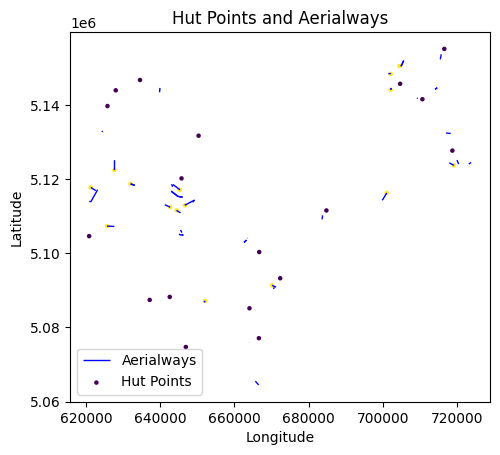

In [112]:
# Plot the hut points and aerialways
fig, ax = plt.subplots()

goods_aerialways.plot(ax=ax, color='blue', linewidth=1, label='Aerialways')
merged_df.plot(ax=ax, c=merged_df['supply_aerialway'], markersize=5, label='Hut Points')

plt.legend()
plt.title('Hut Points and Aerialways')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

HELICOPTER

Huts using helicopter for supplying are: Cevedale, Dorigoni, Stivo, Val di Fumo, Boè, Sette Selle, Rosetta, Vioz (Source: SAT)

In [113]:
merged_df.standard_name.unique()

array(['alpepozzavlancia', 'altissimodchiesa', 'antermoia',
       'bindesipprati', 'boccaditratnpernici', 'boè', 'carèaltodongari',
       'casarotalciola', 'cevedaleglarcher', 'ciampediè',
       'cimadastaobrentari', 'fftucketteqsella', 'finonchiofllifilzi',
       'grostèggraffer', 'mandroncittàditrento', 'montecalinosanpietro',
       'monzonittaramelli', 'paludei', 'peller', 'rodadivael',
       'rosettagpedrotti', 'saentsdorigoni', 'setteselle', 'stavelfdenza',
       'stivopmarchetti', 'tosaetpedrotti', 'vaiolet',
       'valdambiezsagostini', 'valdamolagsegantini', 'valdifumo',
       'velomadonna', 'vioz', 'xiiapostoliflligarbari'], dtype=object)

In [114]:
heli = ['cevedaleglarcher', 'saentsdorigoni', 'stivopmarchetti', 'valdifumo', 'boè', 'setteselle', 'rosettagpedrotti', 'vioz']

def define_helicopter_supply(row):
    if row['standard_name'] in heli:
        return True
    else:
        return False

merged_df['supply_helicopter'] = merged_df.apply(define_helicopter_supply, axis=1)
merged_df['supply_helicopter'].value_counts()


supply_helicopter
False    25
True      8
Name: count, dtype: int64

ROADS

For each hut, use the Point geometry to get the network of roads connected to it. Check the road types: if a car-road is there, I assume it is used for supplying.

In [115]:
# Buffer distance in meters to search for roads near the hut
buffer_dist = 300  # (more than 300 becomes less accurate (gets Stivo which does not have car access))
huts_with_road = {}

merged_df4326 = merged_df.to_crs(epsg=4326) # OSMnx uses WGS84 [degrees] 
for idx, hut in merged_df4326.iterrows():
    hut_point = hut.geometry

    # Get network of roads within a certain distance from the hut's location
    roads_gdf = ox.features.features_from_point(
        (hut_point.y, hut_point.x),
        tags={'highway': True},  # Fetch all roads with 'highway' tag
        dist=buffer_dist
    )

    # Filter vehicle roads (OSM docs key:highway)
    roads_for_vehicles = ['motorway', 'trunk', 'primary', 'secondary', 'tertiary', 'unclassified', 'residential', 'service', 'track'] # track=forestale/agricola
    vehicle_roads = roads_gdf[roads_gdf['highway'].isin(roads_for_vehicles)]
    
    if not vehicle_roads.empty:
      huts_with_road[hut['standard_name']] = vehicle_roads['highway'].unique()

huts_with_road

{'alpepozzavlancia': array(['track'], dtype=object),
 'altissimodchiesa': array(['track'], dtype=object),
 'antermoia': array(['track'], dtype=object),
 'bindesipprati': array(['unclassified', 'track', 'service'], dtype=object),
 'boccaditratnpernici': array(['track'], dtype=object),
 'ciampediè': array(['track'], dtype=object),
 'finonchiofllifilzi': array(['track'], dtype=object),
 'grostèggraffer': array(['track'], dtype=object),
 'montecalinosanpietro': array(['track', 'unclassified'], dtype=object),
 'monzonittaramelli': array(['track'], dtype=object),
 'paludei': array(['residential', 'unclassified', 'track', 'service', 'primary'],
       dtype=object),
 'peller': array(['track'], dtype=object),
 'vaiolet': array(['track'], dtype=object),
 'valdambiezsagostini': array(['track'], dtype=object)}

Most of them are of 'track' type which represents strade forestali, which makes sense.

In [116]:
for idx, row in merged_df.iterrows():
    if row['standard_name'] in huts_with_road:
        merged_df.at[idx, 'supply_road'] = True
    else:
        merged_df.at[idx, 'supply_road'] = False


In [117]:
# Combine all supply modes in a single column
def combine_supply_modes(row):
    supply_mode = []
    if row['supply_aerialway']:
        supply_mode.append('aerialway')
    if row['supply_helicopter']:
        supply_mode.append('helicopter')
    if row['supply_road']:
        supply_mode.append('vehicle')
    
    return supply_mode

merged_df['CR_SU_01'] = merged_df.apply(combine_supply_modes, axis=1)


## Accessibility


CR_AC_01. TYPE OF ACCESS

-> Lifts

From looking in QGIS: there are 3 types of geometries (point, linestring and polygon). Points and polygons are the stations. However, not all lifts have a marked station, so for analysis it may be better to use the linestring (as done with goods aerialways).

I will distinguish between two types of access by lift:
- huts directly accessible via lift (within a 500m (~ 10min) radius from the hut)
- huts with facilitated access thanks to a lift (within a 2.3km radius from the hut)

In [118]:
lifts_aerialways = gpd.read_file('../data/others/lifts_aerialways.geojson')
lifts_aerialways = lifts_aerialways.to_crs(merged_df.crs)

In [119]:
def get_lift_ids_within_buffer(hut_buffer):
    lifts_aerialways_linestring = lifts_aerialways[lifts_aerialways.geometry.type == 'LineString']
    intersecting_lifts = lifts_aerialways_linestring[lifts_aerialways_linestring.intersects(hut_buffer)]
    if not intersecting_lifts.empty:
        # Return all the lift IDs that intersect within the 2300m buffer
        return set(intersecting_lifts['id'])
    else:
        return None

# Directly accessible via lift
merged_df['buffer_500'] = merged_df.geometry.buffer(500)
merged_df['lift_ids_within_500m'] = merged_df['buffer_500'].apply(get_lift_ids_within_buffer)
merged_df = merged_df.drop(columns=['buffer_500'])

# Simplified accessibility via lift
merged_df['buffer_2300'] = merged_df.geometry.buffer(2300)
merged_df['lift_ids_within_2300m'] = merged_df['buffer_2300'].apply(get_lift_ids_within_buffer)
merged_df = merged_df.drop(columns=['buffer_2300'])


For simplicity, for the moment I do not consider the difficulty of the itinerary connecting the lift to the hut. This because the a distance of 2km does not allow much variablity, and the presence of the lift already makes access easier. Note that I checked all the lifts are actually connected to the hut.

In [120]:
merged_df[merged_df['lift_ids_within_500m'].notna()]

,standard_name,nome_strut,categoria_CAISAT,categoria_PAT,posti_letto,quota,geometry,acquedotto,sorgente,superficiale,...,CR_EN_01,CR_EN_02,CR_EN_03,CR_EN_04,supply_aerialway,supply_helicopter,supply_road,CR_SU_01,lift_ids_within_500m,lift_ids_within_2300m
9,ciampediè,CIAMPEDIE',B,Alp,25,1993,POINT (704674.062 5145698.588),1.0,0.0,0,...,"[public_electricity, gas]",2,0.0,public_electricity,False,False,True,[vehicle],"{30792512, 30791793, 30792355, 151641974}","{30792512, 30792482, 30792355, 30792484, 30791..."
13,grostèggraffer,GIORGIO GRAFFER AL GROSTE',C,Alp,70,2261,POINT (645717.304 5120189.926),0.0,1.0,0,...,"[public_electricity, gas]",2,0.0,gasolio,False,False,True,[vehicle],"{42447792, 47405266, 327015525}","{27176128, 327015525, 42447792, 47405266, 3270..."


In [121]:
merged_df[merged_df['lift_ids_within_2300m'].notna()]

,standard_name,nome_strut,categoria_CAISAT,categoria_PAT,posti_letto,quota,geometry,acquedotto,sorgente,superficiale,...,CR_EN_01,CR_EN_02,CR_EN_03,CR_EN_04,supply_aerialway,supply_helicopter,supply_road,CR_SU_01,lift_ids_within_500m,lift_ids_within_2300m
5,boè,BOE',D,Alp,80,2871,POINT (716585.416 5155102.852),0.0,0.0,misto,...,"[public_electricity, gas, solar_thermal]",3,0.0,gasolio,False,True,False,[helicopter],None,{4702284}
9,ciampediè,CIAMPEDIE',B,Alp,25,1993,POINT (704674.062 5145698.588),1.0,0.0,0,...,"[public_electricity, gas]",2,0.0,public_electricity,False,False,True,[vehicle],"{30792512, 30791793, 30792355, 151641974}","{30792512, 30792482, 30792355, 30792484, 30791..."
13,grostèggraffer,GIORGIO GRAFFER AL GROSTE',C,Alp,70,2261,POINT (645717.304 5120189.926),0.0,1.0,0,...,"[public_electricity, gas]",2,0.0,gasolio,False,False,True,[vehicle],"{42447792, 47405266, 327015525}","{27176128, 327015525, 42447792, 47405266, 3270..."
14,mandroncittàditrento,"MANDRON ""CITTA' DI TRENTO""",D,Alp,89,2445,POINT (621213.949 5117752.751),0.0,0.0,torr-lago,...,"[hydroelectric, gas]",2,25.0,elettrico,True,False,False,[aerialway],None,"{32873521, 823434783}"
19,rodadivael,RODA DI VAEL,C,Alp,60,2282,POINT (702109.109 5144095.471),1.0,0.0,0,...,"[cogenerator, photovoltaic, gas]",3,61.4,renewable_option,True,False,False,[aerialway],None,{4699599}
20,rosettagpedrotti,"ROSETTA ""GIOVANNI PEDROTTI""",C,Alp,78,2578,POINT (718762.299 5127676.973),0.0,0.0,fusione,...,"[cogenerator, gas]",2,40.0,elettrico,False,True,False,[helicopter],None,"{39275726, 39275727}"
31,vioz,"VIOZ ""MANTOVA""",E,Alp,60,3531,POINT (625753.000 5139701.000),0.0,0.0,fusione,...,"[cogenerator, gas]",2,80.0,NaN,False,True,False,[helicopter],None,{181081515}


-> Public roads
Use the categoria_PAT column (if "Escurs" then is accessible by car for visitors)

In [122]:
merged_df['car_access'] = merged_df['categoria_PAT'].apply(lambda x: True if x == 'Escurs' else False)

-> Hiking trails
- number of arrival trails

In [123]:
# Buffer hut points by 300 meters and check intersections with trails_gdf
trails_gdf = gpd.read_file('../data/trails/Sentieri_della_SAT.shp')
trails_gdf = trails_gdf.to_crs(merged_df.crs)

# Create a new column 'arrival_trails' to store the names of intersecting trails
merged_df['arrival_trails'] = None

for idx, row in merged_df.iterrows():
    hut_buffer = row['geometry'].buffer(300)
    intersecting_trails = trails_gdf[trails_gdf.intersects(hut_buffer)]
    trail_names = list(intersecting_trails['numero'].unique())
    if trail_names:
        merged_df.at[idx, 'arrival_trails'] = trail_names
    else:
        merged_df.at[idx, 'arrival_trails'] = None

CR_AC_03. REMOTENESS

Assessed using the categoria_CAISAT column. This consists of a classification (for the summer season) in 5 classes (A, B, C, D, E) based on **ease of access for hikers** and **ease of access for supplying**. (Regolamento strutture ricettiva del Club Alpino Italiano, p. 7)

- A: rifugi raggiungibili dalla clientela con auto privata o con massimo 10 minuti a piedi dal parcheggio. Sono incluse anche situazioni dove il cliente raggiunge il rifugio (o le immediate vicinanze) pagando un ticket. 
- B: rifugi raggiungibili con impianto a fune, o nelle strette vicinanze (entro i 10 minuti a piedi dall’arrivo dell’impianto); 
- C, D, E: varia in base a ore di cammino (x escursionista) da tabella CAI (vedi Regolamento). Per quanto riguarda il mezzo di trasporto dei rifornimenti/attrezzature, si assume che il costo in elicottero è il più elevato mentre la teleferica ha un costo una tantum ed ammortizzabile su più anni.

This can be easily converted to numbers from 1 (least remote) to 5 (most remote).


In [124]:
conversion_dict = {
    'A':1,
    'B':2,
    'C':3,
    'D':4,
    'E':5, 
}

# uniform values
merged_df['categoria_CAISAT'] = merged_df['categoria_CAISAT'].str.strip().str.upper()
merged_df['CR_AC_03'] = merged_df['categoria_CAISAT'].map(conversion_dict)

## Hospitality
CR_HO_01. OVERNIGHT CAPACITY

I simply use the posti_letto column

In [125]:
merged_df['CR_HO_01'] = merged_df['posti_letto']

CR_HO_02. SEASONAL OVERNIGHT STAYS (2022)

Extract from sat_pernottamenti.csv


In [126]:
pernottamenti = pd.read_csv('../data/others/sat_pernottamenti.csv')

In [127]:
pernottamenti['standard_name'] = pernottamenti['rifugio'].apply(standardize_name)
merged_df['CR_HO_02'] = merged_df.merge(pernottamenti[['standard_name', '2022']], on='standard_name', how='left')['2022']

In [128]:
merged_df[merged_df['CR_HO_02'].isna()]

,standard_name,nome_strut,categoria_CAISAT,categoria_PAT,posti_letto,quota,geometry,acquedotto,sorgente,superficiale,...,supply_helicopter,supply_road,CR_SU_01,lift_ids_within_500m,lift_ids_within_2300m,car_access,arrival_trails,CR_AC_03,CR_HO_01,CR_HO_02
7,casarotalciola,CASAROTA,C,Alp,32,1569,POINT (670144.420 5091330.693),0.0,1.0,0,...,False,False,[aerialway],None,None,False,"[E442, E432]",3,32,NaN
11,fftucketteqsella,F.F. TUCKETT E Q. SELLA,D,Alp,132,2269,POINT (645234.553 5117100.883),0.0,0.0,fusione,...,False,False,[aerialway],None,None,False,"[O303, O316, O317, O328]",4,132,NaN
21,saentsdorigoni,"SAENT ""SILVIO DORIGONI""",D,Alp,80,2436,POINT (634522.416 5146722.339),0.0,0.0,lago-torr,...,True,False,[helicopter],None,None,False,"[O107, O101, O106]",4,80,NaN
23,stavelfdenza,"STAVEL ""FRANCESCO DENZA""",D,Alp,80,2298,POINT (627603.000 5122421.000),0.0,1.0,0,...,False,False,[aerialway],None,None,False,"[O206, O220, O234]",4,80,NaN
31,vioz,"VIOZ ""MANTOVA""",E,Alp,60,3531,POINT (625753.000 5139701.000),0.0,0.0,fusione,...,True,False,[helicopter],None,{181081515},False,[O105],5,60,NaN
32,xiiapostoliflligarbari,"DODICI APOSTOLI ""F.LLI GARBARI""",D,Alp,38,2488,POINT (642662.327 5112444.058),0.0,0.0,fusione,...,False,False,[aerialway],None,None,False,"[O304, O321, O341, O341A, O307]",4,38,NaN


These names are different so I set them manually from looking at the csv:

In [129]:
merged_df.loc[merged_df['standard_name'] == 'casarotalciola', 'CR_HO_02'] = 102
merged_df.loc[merged_df['standard_name'] == 'fftucketteqsella', 'CR_HO_02'] = 4883
merged_df.loc[merged_df['standard_name'] == 'saentsdorigoni', 'CR_HO_02'] = 2283
merged_df.loc[merged_df['standard_name'] == 'stavelfdenza', 'CR_HO_02'] = 903
merged_df.loc[merged_df['standard_name'] == 'vioz', 'CR_HO_02'] = 1318
merged_df.loc[merged_df['standard_name'] == 'xiiapostoliflligarbari', 'CR_HO_02'] = 1100

In [130]:
merged_df.head(7)

,standard_name,nome_strut,categoria_CAISAT,categoria_PAT,posti_letto,quota,geometry,acquedotto,sorgente,superficiale,...,supply_helicopter,supply_road,CR_SU_01,lift_ids_within_500m,lift_ids_within_2300m,car_access,arrival_trails,CR_AC_03,CR_HO_01,CR_HO_02
0,alpepozzavlancia,"ALPE POZZA ""VINCENZO LANCIA""",C,Alp,50,1802,POINT (666584.351 5077095.370),0.0,1.0,0,...,False,True,[vehicle],None,None,False,"[E101, E102, E105, E131, E120, E132]",3,50,1084.0
1,altissimodchiesa,"ALTISSIMO ""DAMIANO CHIESA""",C,Alp,35,2060,POINT (646874.183 5074717.942),0.0,1.0,0,...,False,True,[vehicle],None,None,False,"[O622, O633, O601]",3,35,401.0
2,antermoia,ANTERMOIA,D,Alp,61,2496,POINT (704489.000 5150499.000),0.0,0.0,torr-lago,...,False,True,"[aerialway, vehicle]",None,None,False,"[E584, E580, E583]",4,61,4002.0
3,bindesipprati,"BINDESI ""PINO PRATI""",A,Escurs,0,618,POINT (666672.806 5100323.693),1.0,0.0,0,...,False,True,[vehicle],None,None,True,[E412],1,0,0.0
4,boccaditratnpernici,"BOCCA DI TRAT ""NINO PERNICI""",C,Alp,28,1601,POINT (637133.000 5087416.000),0.0,1.0,0,...,False,True,[vehicle],None,None,False,"[O413, O402, O420, O403, O445]",3,28,470.0
5,boè,BOE',D,Alp,80,2871,POINT (716585.416 5155102.852),0.0,0.0,misto,...,True,False,[helicopter],None,{4702284},False,"[E627, E638, E647, E647A]",4,80,3174.0
6,carèaltodongari,"CARE' ALTO ""DANTE ONGARI""",D,Alp,74,2450,POINT (625663.479 5107292.054),0.0,0.0,torr-rio,...,False,False,[aerialway],None,None,False,"[O213A, O222, O215, O213]",4,74,1174.0


## Select only criterias, name and geometry

In [131]:
criteria_cols = [col for col in merged_df.columns if 'CR_' in col]
alternatives_gdf = merged_df[['standard_name', 'geometry'] + criteria_cols]

In [132]:
alternatives_gdf

,standard_name,geometry,CR_WA_01,CR_WA_03,CR_EN_01,CR_EN_02,CR_EN_03,CR_EN_04,CR_SU_01,CR_AC_03,CR_HO_01,CR_HO_02
0,alpepozzavlancia,POINT (666584.351 5077095.370),spring,40.0,"[generator, photovoltaic, gas]",3,41.8,gasolio,[vehicle],3,50,1084.0
1,altissimodchiesa,POINT (646874.183 5074717.942),spring,30.0,"[generator, photovoltaic, gas]",3,22.5,renewable_option,[vehicle],3,35,401.0
2,antermoia,POINT (704489.000 5150499.000),torr-lago,18.0,"[cogenerator, photovoltaic, gas]",3,61.4,gasolio,"[aerialway, vehicle]",4,61,4002.0
3,bindesipprati,POINT (666672.806 5100323.693),aqueduct,NaN,"[public_electricity, gas]",2,0.0,public_electricity,[vehicle],1,0,0.0
4,boccaditratnpernici,POINT (637133.000 5087416.000),spring,20.0,"[generator, photovoltaic, gas]",3,41.2,renewable_option,[vehicle],3,28,470.0
5,boè,POINT (716585.416 5155102.852),misto,100.0,"[public_electricity, gas, solar_thermal]",3,0.0,gasolio,[helicopter],4,80,3174.0
6,carèaltodongari,POINT (625663.479 5107292.054),torr-rio,2.0,[hydroelectric],1,25.0,elettrico,[aerialway],4,74,1174.0
7,casarotalciola,POINT (670144.420 5091330.693),spring,20.0,"[generator, photovoltaic, gas]",3,21.0,renewable_option,[aerialway],3,32,102.0
8,cevedaleglarcher,POINT (627983.759 5143939.751),torr-rio,30.0,"[cogenerator, gas]",2,40.0,gasolio,[helicopter],4,88,1027.0
9,ciampediè,POINT (704674.062 5145698.588),aqueduct,NaN,"[public_electricity, gas]",2,0.0,public_electricity,[vehicle],2,25,216.0
